In [16]:
ion1 = -2
ion2 = 3
nions = 13
nseg = 25

new_file_suffix = "v2"  # new filename will be  <date>_am_<nions>_<new_file_suffix>.json
prev_solution_file = "../out/20260205_am_13_v1.json"  # previous solution to use as initial guess

params_file = "../system_params/072125_goldparams_13ions.json"

"../system_params/072125_goldparams_13ions.json"

In [17]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

sysparams = open(params_file) do io
    read(io, GoldGates.SystemParams; format=:json)
end

date = Dates.format(Dates.now(), "yyyymmdd")
out_file = "../out/$(date)_am_$(nions)_$(new_file_suffix).json"

# === Load previous solution metadata ===
prev_ion_pair_key = join(sort([ion1, ion2], rev=true), ",")
prev_meta = load_solution_metadata(prev_solution_file, prev_ion_pair_key)
if prev_meta === nothing
    error("No metadata found for $prev_ion_pair_key in $prev_solution_file")
end

prev_params = get(prev_meta, "opt_params", nothing)
if prev_params === nothing
    error("No opt_params found in previous solution. Cannot do warm-start.")
end

# Optimizer settings from previous solution
pitime = prev_meta["pitime"]
τmin = prev_meta["τmin"]
τmax = prev_meta["τmax"]
maxtime = prev_meta["maxtime"]
min_mode_index = Int(prev_meta["min_mode_index"])
max_mode_index = Int(prev_meta["max_mode_index"])
println("Previous optimizer config: pitime=$pitime, τ=[$τmin, $τmax], modes=[$min_mode_index, $max_mode_index]")

Previous optimizer config: pitime=8, τ=[5, 15], modes=[1, 2]


(obj = 0.08470217277921485, dis = 9.867688925528145e-5, disδ = 8.420093713542219, area = -1.5705266631111474, areaε = -0.00026966368374914396, areaδ = 7.611486602054573, total_t = 346.7004372435375, Ωmax = 0.00046146984565949615)
(obj = 0.010781965343836688, dis = 1.4341037889045954e-5, disδ = 1.0709401876450066, area = -1.5707620026524527, areaε = -3.43241424438645e-5, areaδ = 8.605017524331807, total_t = 317.205886104495, Ωmax = 0.0)
(obj = 2.1634160736800856e-5, dis = 8.481477715550865e-9, disδ = 0.001982915217988954, area = -1.570796252088168, areaε = -7.470672858111982e-8, areaδ = -13.276296961969589, total_t = 328.50591456459637, Ωmax = 0.0)
(obj = 5.665926800925479e-6, dis = 3.460863646323153e-9, disδ = 0.0003718541696827662, area = -1.5707963022542257, areaε = -2.454067082879874e-8, areaδ = -13.892734524353905, total_t = 328.79900474926654, Ωmax = 9.25055759783703e-6)
(obj = 5.665926800710515e-6, dis = 3.460822508539168e-9, disδ = 0.0003718542006037409, area = -1.57079630362574

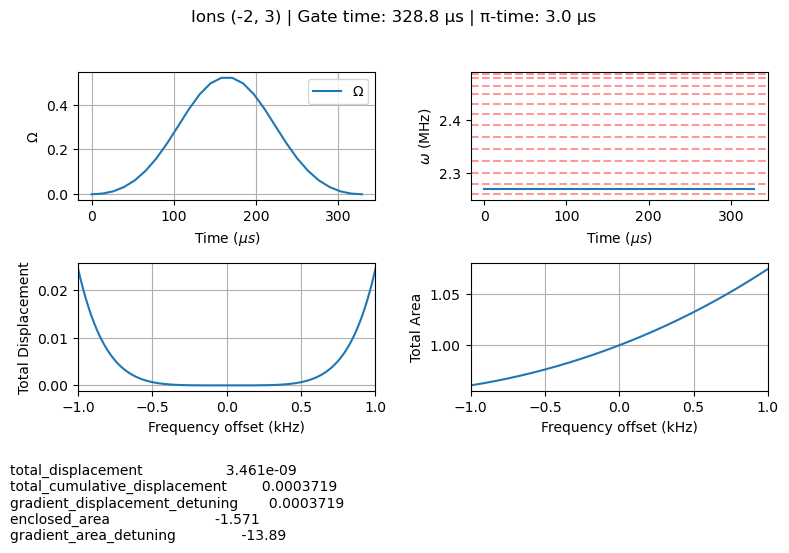

In [18]:
# === Build model & optimizer using previous solution's config ===
modes = setup_modes(sysparams, ion1, ion2, nions)
nlmodel = setup_model(nseg, modes)
opt, tracker = setup_optimizer(nlmodel, sysparams; pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)

# === Optimize (warm start from previous solution) ===
best_params, best_obj = run_optimization!(opt, tracker, nlmodel;
    initial_params=prev_params, perturbation=0.05)

# === Review results & save ===
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params, nseg, sysparams, modes;
    ion1, ion2, pitime, τmin, τmax, maxtime, min_mode_index, max_mode_index)
verify_solution(metadata)
save_am_solution(out_file, opt_raw_params, metadata, sysparams, ion1, ion2)